## 1. Data preparation


1.1 Importing libraries

In [1]:
import pandas as pd
import numpy as np
from numba import cuda
import torch.cuda
from google.colab import runtime
import torch
import numpy as np
import pandas as pd
import io
import os
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
!pip install datasets

from datasets import Dataset, load_metric
import json

from time import sleep

# install openai
!pip install -U openai

from openai import OpenAI
client = OpenAI(api_key="secret_key")

from collections import defaultdict
import numpy as np

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

1.2 Importing data

In [ ]:
dc = pd.read_excel('/content/DecOp_data_EN_500.xlsx',header = 0)

dc.head()



d1 = []
for i in range(dc.shape[0]):
  row = dc.iloc[i]
  d1.append({'ID': row['ID'],
      'age' :row['age'], 'gender': row['gender'],
  'sent' : row['A'].replace('\n', " ") ,
  'labels'  : row['GT.A'],
  'type': 'Abortion' })

  d1.append({'ID': row['ID'],
      'age' :row['age'], 'gender': row['gender'],
  'sent' : row['E'].replace('\n', " ")  ,
  'labels'  : row['GT.E'],
  'type': 'Euthanasia'

             })


  d1.append({'ID': row['ID'],
      'age' :row['age'], 'gender': row['gender'],
  'sent' : row['GM'].replace('\n', " ")  ,
  'labels'  : row['GT.GM'],
  'type': 'Gay Marriage'


             })

  d1.append({'ID': row['ID'],
      'age' :row['age'], 'gender': row['gender'],
  'sent' : row['Pom'].replace('\n', " ")  ,
  'labels'  : row['GT.Pom'],
  'type': 'Migration'
             })

  d1.append({'ID': row['ID'],
      'age' :row['age'], 'gender': row['gender'],
  'sent' : row['CL'].replace('\n', " ")  ,
  'labels'  : row['GT.CL'],
  'type': 'Cannabis legalization'

             })

decop = pd.DataFrame.from_records(d1)

decop=decop[['ID', 'sent', 'labels','type']]

In [ ]:
# showing some rows of the dataset we are going to use

decop[:15]

,ID,sent,labels,type
0,1,Abortion should be banned! People are killing ...,False,Abortion
1,1,I'm assuming we're talking about animals... eu...,True,Euthanasia
2,1,I think gay marriage is just a normal as strai...,True,Gay Marriage
3,1,We need to keep them out of the country. They ...,False,Migration
4,1,I think it should be legalized and regulated l...,True,Cannabis legalization
5,2,I believe in a woman's right to choose to abor...,False,Abortion
6,2,I don't believe in taking one's own life. Only...,True,Euthanasia
7,2,I am against gay marriage. The Bible is my gu...,True,Gay Marriage
8,2,We should allow all migrants in to this countr...,False,Migration
9,2,I am for cannabis legalization for medicinal p...,True,Cannabis legalization


1.3 Create dataset

This custom function is adapted from the original paper, with modifications to utilize only the portion pertaining to the Scenario 1 Opinioni dataset.

In [ ]:

def create_dataset(Scenario={'train': [], 'test': [], 'scenario': 1}, decop=None, seed=42, cv=4):

    # generate training and testing set based on Scenario dictionary
    # cv number of cross-validation

    # initialize dictionaries to store train and test dataset for each split
    train = {f'split_{i + 1}': [] for i in range(cv)}
    test = {f'split_{i + 1}': [] for i in range(cv)}

    # generate shuffled indices for data splits
    np.random.seed(seed)

    de_arr = np.arange(1, 501)
    np.random.shuffle(de_arr)
    de_arr_r = de_arr.reshape((cv, int(500 / cv)))

    # generate train/test split
    # iterates over the splits and based on the scenario create train and test set.

    cv_ind = 0
    for k in train.keys():

        if Scenario['scenario'] == 1:

            if 'decop' in Scenario['train']:
                ind = de_arr_r[cv_ind, :]
                antind = [i for i in de_arr if i not in ind]

                decop_train = decop[decop['ID'].isin(antind)]
                decop_test = decop[decop['ID'].isin(ind)]

                train[k].append(decop_train)
                test[k].append(decop_test)

            train[k] = pd.concat(train[k])
            test[k] = pd.concat(test[k])

        cv_ind += 1

    return train, test

## 2. GPT 3.5 API


2.1 Prepare data in jsonl format


In [ ]:
DEFAULT_SYSTEM_PROMPT ='Given a statement, your task is to determine if the user is honest (T) or not (F) about their opinion.'

def create_jsonl(dataset: pd.DataFrame, file_name: str) -> None:
    with open(f'{file_name}.jsonl', 'w') as file:
        for row in dataset.itertuples():
            file.write(json.dumps({
                "messages": [{"role": "system", "content": DEFAULT_SYSTEM_PROMPT},
                             {"role": "user", "content": row.sent},
                             {"role": "assistant", "content": row.labels}                             ]
                })+'\n')
    file.close()


In [ ]:
# store jsonl for testing purpose
# store excel file to be used later on to get the response of GPT 3.5 for each user statement
seed = 42
np.random.seed(seed)
numcv = 4
dataset = ['decop']
Scenario = {'train': dataset, 'test': dataset, 'scenario': 1}
train, test = create_dataset(Scenario, decop=decop, seed=seed, cv=numcv)

# Iterate through scenarios
for sp in tqdm(train.keys()):
    data_train = train[sp]
    data_test = test[sp]

    # Create JSONL files
    train_filename = f"training_scenario_{sp}"
    test_filename = f"testing_scenario_{sp}"
    create_jsonl(data_train, train_filename)
    create_jsonl(data_test, test_filename)

    # Create Excel files
    train_excel_filename = f"training_scenario_{sp}.xlsx"
    test_excel_filename = f"testing_scenario_{sp}.xlsx"

    # Convert data to pandas DataFrame
    train_df = pd.DataFrame(data_train)
    test_df = pd.DataFrame(data_test)

    # Write DataFrames to Excel files
    train_df.to_excel(train_excel_filename, index=False)
    test_df.to_excel(test_excel_filename, index=False)

    sleep(10)
    print(f"Scenario {sp}: DONE")
    sleep(10)


In [ ]:
# store openAI key in this waay just for the fine-tuning process

import openai
openai.api_key = "secret_key"

2.2 Fine-tuning the model



In [ ]:
seed = (42)
np.random.seed(seed)
numcv = 4
dataset = ['decop']
Scenario = {'train': dataset, 'test': dataset, 'scenario': 1}
train, test = create_dataset(Scenario, decop=decop, seed=seed, cv=numcv)

# here I just tested how it works the split and how the json file looks like

for sp in tqdm(train.keys()):

    data_train = train[sp]
    data_test = test[sp]

    create_jsonl(data_train, "training")
    create_jsonl(data_test, "testing")


    sleep(30)


    training_file = openai.File.create(
        file = open("training.jsonl","rb"),
         purpose = "fine-tune"
    )

    sleep(30)

    validation_file = openai.File.create(
        file = open("testing.jsonl","rb"),
         purpose = "fine-tune"
    )

    sleep(30)

    training_file_id = training_file.id # in one article is used training_file.id
    validation_file_id = validation_file.id

    sleep(30)

    fine_tuning_job = openai.FineTuningJob.create(
                                                 training_file = training_file_id,
                                                 validation_file = validation_file_id,
                                                 model="gpt-3.5-turbo",
                                                 hyperparameters={"n_epochs": 3}

                                                   )

    sleep(90)




## 3. Model Results


The format_test function prepares a test message structure for model testing, including a system prompt and user input. Predict uses a fine-tuned model to generate predictions based on a list of formatted test messages. Finally, the store_predictions function takes a DataFrame of test data, employs the format_test and predict functions to generate and store predictions in a new 'Prediction' column, and then saves the updated DataFrame to a CSV file named 'predictions.csv'.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def format_test(row):

# Formats a test message for a chatbot testing scenario.

#    Parameters:
#   - row (dict): A dictionary representing a row of test data.
#       It should contain at least a 'sent' key representing the user's input.

#    Returns:
#    list of dict: A formatted message for testing, represented as a list of
# dictionaries.
#        Each dictionary has two keys:
#            - 'role': Specifies the role of the message ('system' or 'user').
#            - 'content': Contains the content of the message.

    formatted_message = [

         {"role": "system", "content": DEFAULT_SYSTEM_PROMPT},
         {"role": "user", "content": row['sent']}

         ]
    return formatted_message

def predict(test_messages, fine_tuned_model_id):

# Generates a model prediction based on input test messages using a fine-tuned
# language model.

#    Parameters:
#    - test_messages (list of dict): List of messages for the chatbot model to
# process.
#       Each message is represented as a dictionary with 'role' ('system' or 'user') # and 'content'.


#   - fine_tuned_model_id (str): The ID or name of the fine-tuned language model to
# be used for prediction.

#   Returns:
#   str: The predicted response generated by the language model.

    response = client.chat.completions.create(
        model=fine_tuned_model_id,
        messages = test_messages

    )
    return response.choices[0].message.content

def store_predictions(test_df, fine_tuned_model_id):

# Generates predictions using a fine-tuned language model for each row in the given
# DataFrame
#    and stores the predictions in a new 'Prediction' column. The resulting DataFrame # is then saved
#   to a CSV file named 'predictions.csv'.

#    Parameters:
#    - test_df (pandas DataFrame): The DataFrame containing test data, where each row # represents a test case.

#    - fine_tuned_model_id (str): The ID or name of the fine-tuned language model to be used for prediction.

    test_df['Prediction'] = None
    for index, row in test_df.iterrows():
        test_message = format_test(row)
        prediction_result = predict(test_message, fine_tuned_model_id)
        test_df.at[index, 'Prediction'] = prediction_result

    test_df.to_csv("predictions.csv")


3.1 First fold


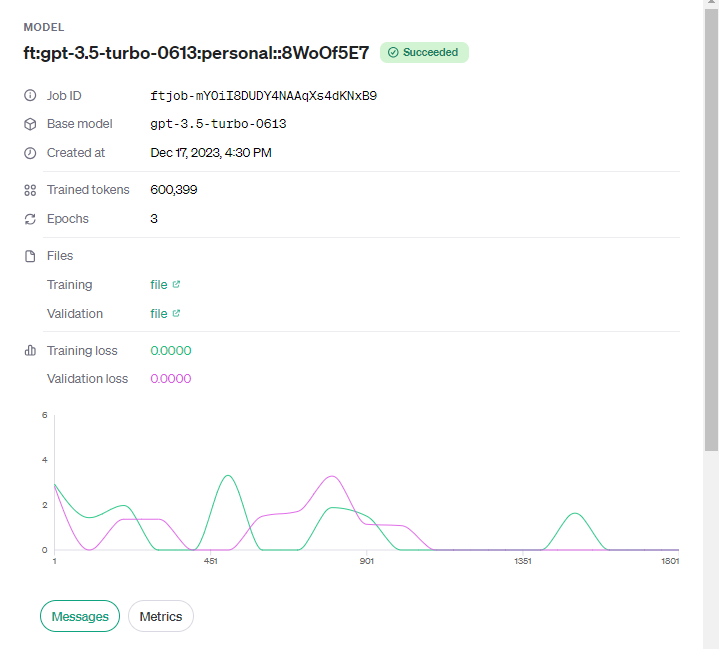

In [ ]:
# Specify the file path
excel_file_path = '/content/testing_scenario_split_1.xlsx'

# Read the Excel file into a DataFrame
df_testing_scenario_split_1 = pd.read_excel(excel_file_path)

# Display the DataFrame
df_testing_scenario_split_1.head()


,ID,sent,labels,type
0,1,Abortion should be banned! People are killing ...,F,Abortion
1,1,I'm assuming we're talking about animals... eu...,T,Euthanasia
2,1,I think gay marriage is just a normal as strai...,T,Gay Marriage
3,1,We need to keep them out of the country. They ...,F,Migration
4,1,I think it should be legalized and regulated l...,T,Cannabis legalization


In [ ]:
fine_tuned_model_id = 'ft:gpt-3.5-turbo-0613:personal::8WoOf5E7'

In [ ]:
store_predictions(df_testing_scenario_split_1, fine_tuned_model_id)

In [ ]:
predictions_df = pd.read_csv("predictions.csv")

3.1.1 First fold overall metrics

In [ ]:
true_labels = predictions_df['labels']
predicted_labels = predictions_df['Prediction']

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Precision: {precision:.4f}")

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Recall: {recall:.4f}")

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8816
Precision: 0.8692
Recall: 0.8971
F1 Score: 0.8829


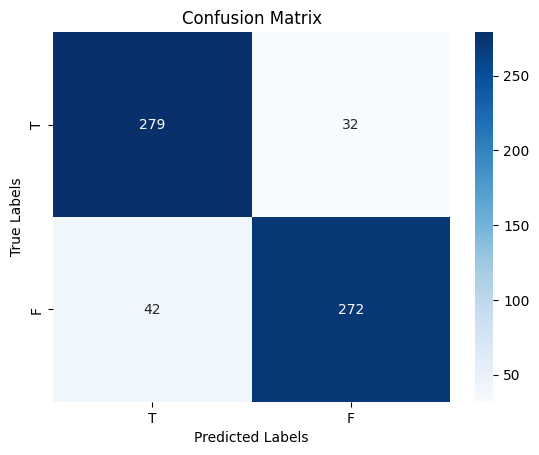

In [ ]:
# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['T', 'F'])

# Display the confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['T', 'F'], yticklabels=['T', 'F'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

3.1.2 First fold metrics for each statement type

In [ ]:

true_labels = predictions_df['labels']
predicted_labels = predictions_df['Prediction']
types = predictions_df['type']

# Calculate overall metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='binary', pos_label='T')
recall = recall_score(true_labels, predicted_labels, average='binary', pos_label='T')
f1 = f1_score(true_labels, predicted_labels, average='binary', pos_label='T')

print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall: {recall:.4f}")
print(f"Overall F1 Score: {f1:.4f}")
print()

# Calculate metrics for each type
unique_types = predictions_df['type'].unique()

for t in unique_types:
    type_mask = (types == t)
    type_true_labels = true_labels[type_mask]
    type_predicted_labels = predicted_labels[type_mask]

    type_accuracy = accuracy_score(type_true_labels, type_predicted_labels)
    type_precision = precision_score(type_true_labels, type_predicted_labels, average='binary', pos_label='T')
    type_recall = recall_score(type_true_labels, type_predicted_labels, average='binary', pos_label='T')
    type_f1 = f1_score(type_true_labels, type_predicted_labels, average='binary', pos_label='T')

    print(f"Metrics for Type {t}:")
    print(f"  Accuracy: {type_accuracy:.4f}")
    print(f"  Precision: {type_precision:.4f}")
    print(f"  Recall: {type_recall:.4f}")
    print(f"  F1 Score: {type_f1:.4f}")
    print()

Overall Accuracy: 0.8816
Overall Precision: 0.8692
Overall Recall: 0.8971
Overall F1 Score: 0.8829

Metrics for Type Abortion:
  Accuracy: 0.8720
  Precision: 0.8621
  Recall: 0.8621
  F1 Score: 0.8621

Metrics for Type Euthanasia:
  Accuracy: 0.8560
  Precision: 0.8769
  Recall: 0.8507
  F1 Score: 0.8636

Metrics for Type Gay Marriage:
  Accuracy: 0.9040
  Precision: 0.8767
  Recall: 0.9552
  F1 Score: 0.9143

Metrics for Type Migration:
  Accuracy: 0.8960
  Precision: 0.8947
  Recall: 0.8793
  F1 Score: 0.8870

Metrics for Type Cannabis legalization:
  Accuracy: 0.8800
  Precision: 0.8382
  Recall: 0.9344
  F1 Score: 0.8837



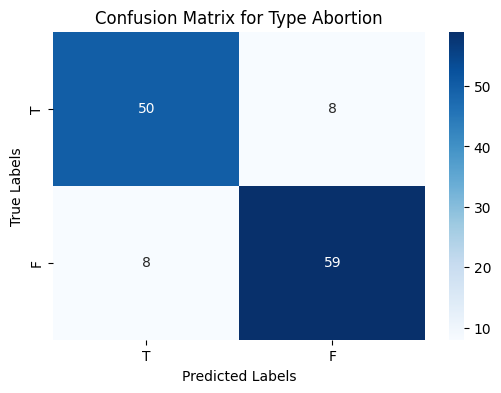

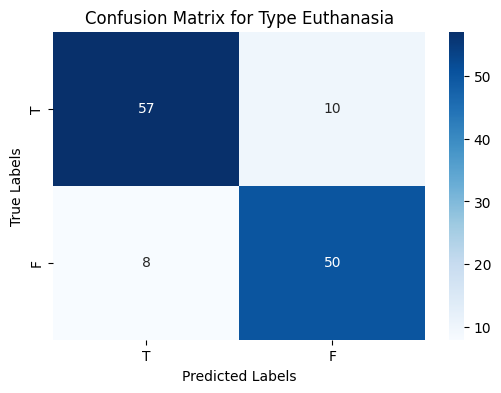

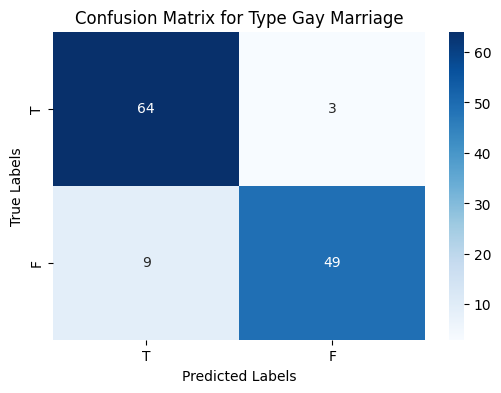

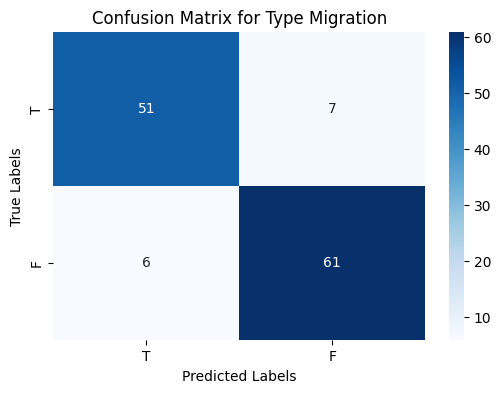

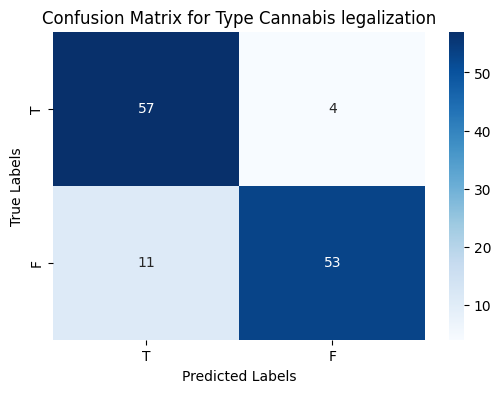

In [ ]:
# Create confusion matrices for each type
for t in unique_types:
    type_mask = (types == t)
    type_true_labels = true_labels[type_mask]
    type_predicted_labels = predicted_labels[type_mask]

    # Create a confusion matrix
    conf_matrix = confusion_matrix(type_true_labels, type_predicted_labels, labels=['T', 'F'])

    # Display the confusion matrix using seaborn heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['T', 'F'], yticklabels=['T', 'F'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for Type {t}')
    plt.show()

3.2 Second fold

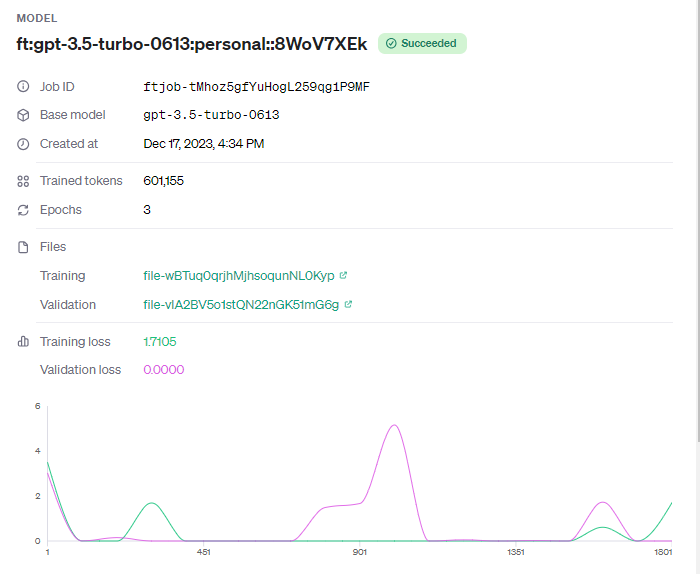

In [ ]:
# Specify the file path
excel_file_path = '/content/testing_scenario_split_2.xlsx'

# Read the Excel file into a DataFrame
df_testing_scenario_split_2 = pd.read_excel(excel_file_path)

# Display the DataFrame
df_testing_scenario_split_2.head()

,ID,sent,labels,type
0,4,Abortion is so terrible! I don't understand wh...,False,Abortion
1,4,"If someone was suffering and wanted to die, th...",True,Euthanasia
2,4,"Gay Marriage is okay. I am not against it, and...",True,Gay Marriage
3,4,Migrants are taking all of our jobs! We do not...,False,Migration
4,4,"People smoke weed all the time, and the war on...",True,Cannabis legalization


In [ ]:
fine_tuned_model_id_2cv = 'ft:gpt-3.5-turbo-0613:personal::8WoV7XEk'
store_predictions(df_testing_scenario_split_2, fine_tuned_model_id_2cv)

In [ ]:
predictions_2cv_df = pd.read_csv("predictions.csv")

3.2.1 Second fold overall metrics

In [6]:
true_labels = predictions_2cv_df['labels']
predicted_labels = predictions_2cv_df['Prediction']

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Precision: {precision:.4f}")

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Recall: {recall:.4f}")

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.8512
Precision: 0.8904
Recall: 0.8100
F1 Score: 0.8483


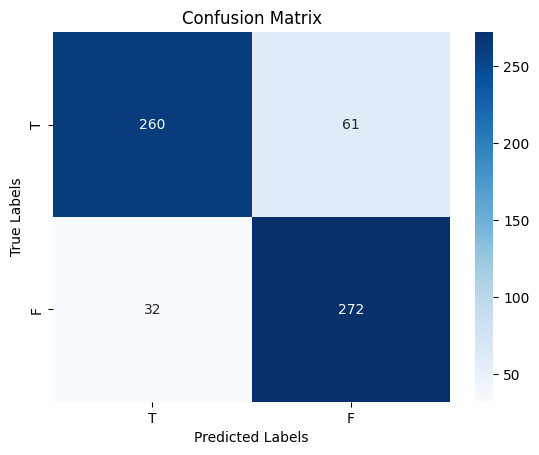

In [7]:
# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['T', 'F'])

# Display the confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['T', 'F'], yticklabels=['T', 'F'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

3.2.2 Second fold metrics for each statement type

In [ ]:
true_labels = predictions_2cv_df['labels']
predicted_labels = predictions_2cv_df['Prediction']
types = predictions_2cv_df['type']

# Calculate overall metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='binary', pos_label='T')
recall = recall_score(true_labels, predicted_labels, average='binary', pos_label='T')
f1 = f1_score(true_labels, predicted_labels, average='binary', pos_label='T')

print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall: {recall:.4f}")
print(f"Overall F1 Score: {f1:.4f}")
print()

# Calculate metrics for each type
unique_types = predictions_2cv_df['type'].unique()

for t in unique_types:
    type_mask = (types == t)
    type_true_labels = true_labels[type_mask]
    type_predicted_labels = predicted_labels[type_mask]

    type_accuracy = accuracy_score(type_true_labels, type_predicted_labels)
    type_precision = precision_score(type_true_labels, type_predicted_labels, average='binary', pos_label='T')
    type_recall = recall_score(type_true_labels, type_predicted_labels, average='binary', pos_label='T')
    type_f1 = f1_score(type_true_labels, type_predicted_labels, average='binary', pos_label='T')

    print(f"Metrics for Type {t}:")
    print(f"  Accuracy: {type_accuracy:.4f}")
    print(f"  Precision: {type_precision:.4f}")
    print(f"  Recall: {type_recall:.4f}")
    print(f"  F1 Score: {type_f1:.4f}")
    print()

Overall Accuracy: 0.8512
Overall Precision: 0.8904
Overall Recall: 0.8100
Overall F1 Score: 0.8483

Metrics for Type Abortion:
  Accuracy: 0.8320
  Precision: 0.8679
  Recall: 0.7667
  F1 Score: 0.8142

Metrics for Type Euthanasia:
  Accuracy: 0.8400
  Precision: 0.9091
  Recall: 0.7692
  F1 Score: 0.8333

Metrics for Type Gay Marriage:
  Accuracy: 0.8640
  Precision: 0.9138
  Recall: 0.8154
  F1 Score: 0.8618

Metrics for Type Migration:
  Accuracy: 0.8960
  Precision: 0.9123
  Recall: 0.8667
  F1 Score: 0.8889

Metrics for Type Cannabis legalization:
  Accuracy: 0.8240
  Precision: 0.8551
  Recall: 0.8310
  F1 Score: 0.8429



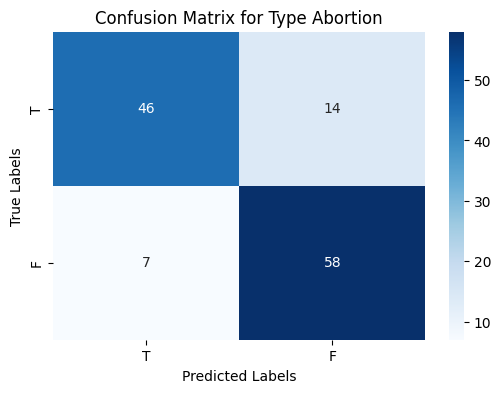

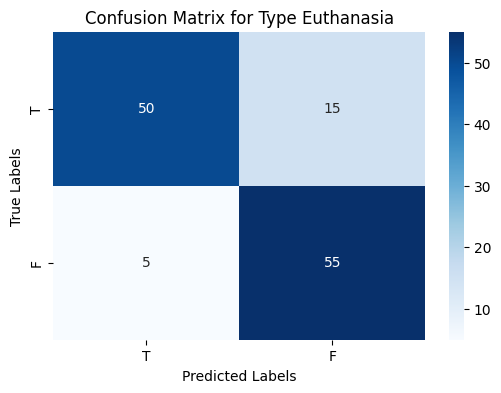

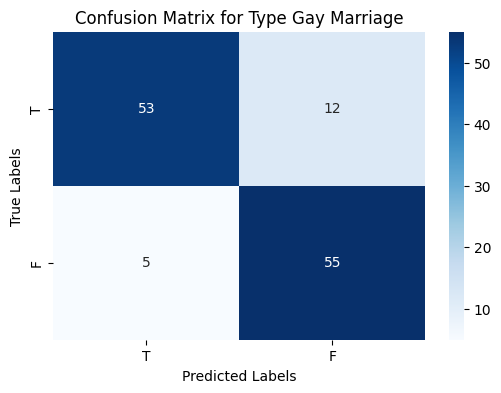

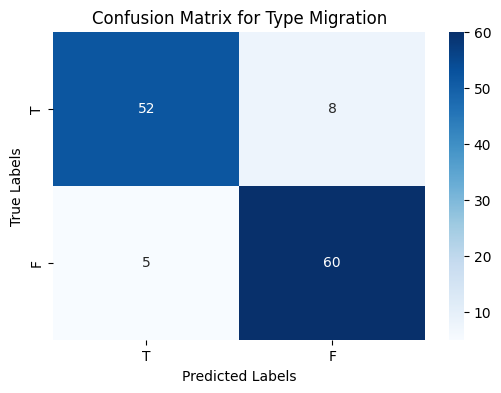

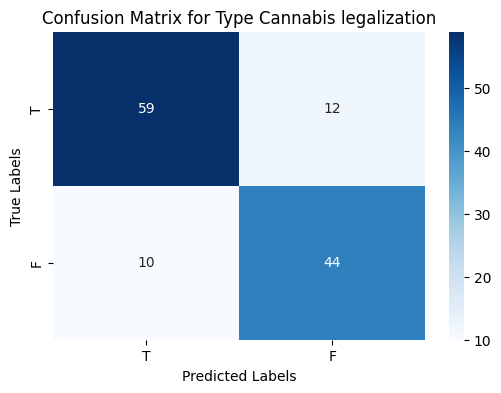

In [ ]:
# Create confusion matrices for each type
for t in unique_types:
    type_mask = (types == t)
    type_true_labels = true_labels[type_mask]
    type_predicted_labels = predicted_labels[type_mask]

    # Create a confusion matrix
    conf_matrix = confusion_matrix(type_true_labels, type_predicted_labels, labels=['T', 'F'])

    # Display the confusion matrix using seaborn heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['T', 'F'], yticklabels=['T', 'F'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for Type {t}')
    plt.show()

3.3 Third fold

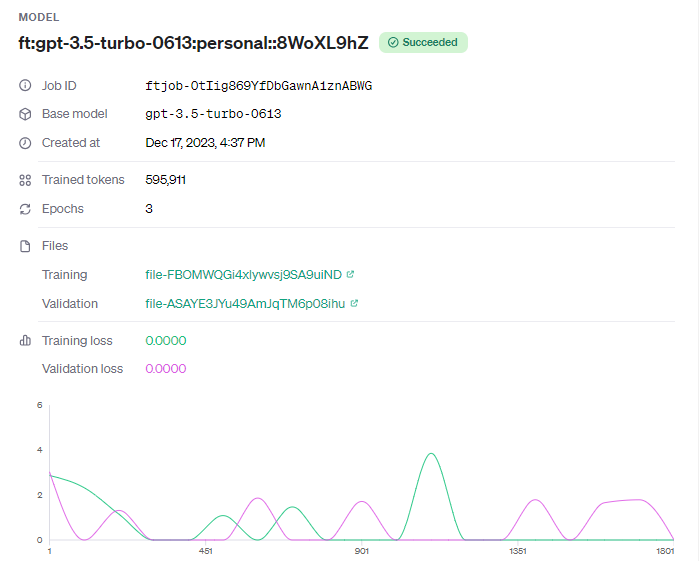

In [ ]:
# Specify the file path
excel_file_path = '/content/testing_scenario_split_3.xlsx'

# Read the Excel file into a DataFrame
df_testing_scenario_split_3 = pd.read_excel(excel_file_path)
df_testing_scenario_split_3['labels'] = df_testing_scenario_split_3['labels'].replace({True: 'T', False: 'F'})
# Display the DataFrame
df_testing_scenario_split_3.head()

,ID,sent,labels,type
0,5,I think it should not be a womans choice wheth...,F,Abortion
1,5,I think this is awful. Only God can decide whe...,T,Euthanasia
2,5,I think gay marriage is a great thing. No one ...,T,Gay Marriage
3,5,Migrants should be welcome with no government ...,F,Migration
4,5,Why not start having to pay tax on it and regu...,T,Cannabis legalization


In [ ]:
fine_tuned_model_id_3_cv = 'ft:gpt-3.5-turbo-0613:personal::8WoXL9hZ'
store_predictions(df_testing_scenario_split_3, fine_tuned_model_id_3_cv)
predictions_3cv_df = pd.read_csv("predictions.csv")

3.3.1 Third fold overall metrics

In [9]:

true_labels = predictions_3cv_df['labels']
predicted_labels = predictions_3cv_df['Prediction']

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Precision: {precision:.4f}")

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Recall: {recall:.4f}")

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.8688
Precision: 0.8775
Recall: 0.8548
F1 Score: 0.8660


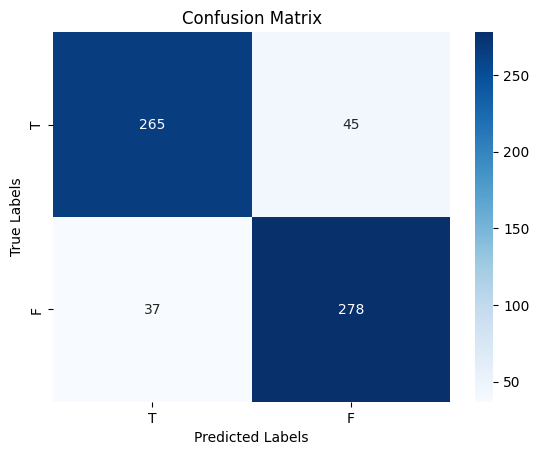

In [10]:

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['T', 'F'])

# Display the confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['T', 'F'], yticklabels=['T', 'F'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

3.3.2 Third fold metrics for each statement type

In [ ]:
true_labels = predictions_3cv_df['labels']
predicted_labels = predictions_3cv_df['Prediction']
types = predictions_3cv_df['type']

# Calculate overall metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='binary', pos_label='T')
recall = recall_score(true_labels, predicted_labels, average='binary', pos_label='T')
f1 = f1_score(true_labels, predicted_labels, average='binary', pos_label='T')

print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall: {recall:.4f}")
print(f"Overall F1 Score: {f1:.4f}")
print()

# Calculate metrics for each type
unique_types = predictions_2cv_df['type'].unique()

for t in unique_types:
    type_mask = (types == t)
    type_true_labels = true_labels[type_mask]
    type_predicted_labels = predicted_labels[type_mask]

    type_accuracy = accuracy_score(type_true_labels, type_predicted_labels)
    type_precision = precision_score(type_true_labels, type_predicted_labels, average='binary', pos_label='T')
    type_recall = recall_score(type_true_labels, type_predicted_labels, average='binary', pos_label='T')
    type_f1 = f1_score(type_true_labels, type_predicted_labels, average='binary', pos_label='T')

    print(f"Metrics for Type {t}:")
    print(f"  Accuracy: {type_accuracy:.4f}")
    print(f"  Precision: {type_precision:.4f}")
    print(f"  Recall: {type_recall:.4f}")
    print(f"  F1 Score: {type_f1:.4f}")
    print()

Overall Accuracy: 0.8688
Overall Precision: 0.8775
Overall Recall: 0.8548
Overall F1 Score: 0.8660

Metrics for Type Abortion:
  Accuracy: 0.8400
  Precision: 0.8906
  Recall: 0.8143
  F1 Score: 0.8507

Metrics for Type Euthanasia:
  Accuracy: 0.8880
  Precision: 0.8596
  Recall: 0.8909
  F1 Score: 0.8750

Metrics for Type Gay Marriage:
  Accuracy: 0.9120
  Precision: 0.9231
  Recall: 0.8727
  F1 Score: 0.8972

Metrics for Type Migration:
  Accuracy: 0.8720
  Precision: 0.8857
  Recall: 0.8857
  F1 Score: 0.8857

Metrics for Type Cannabis legalization:
  Accuracy: 0.8320
  Precision: 0.8305
  Recall: 0.8167
  F1 Score: 0.8235



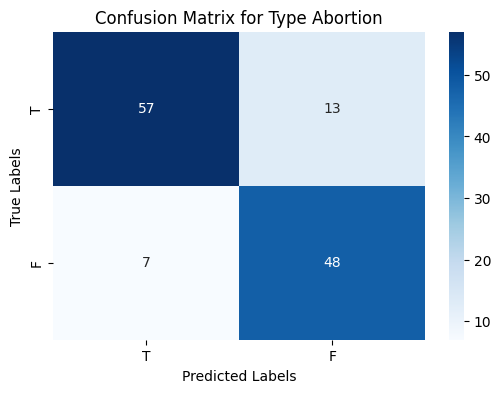

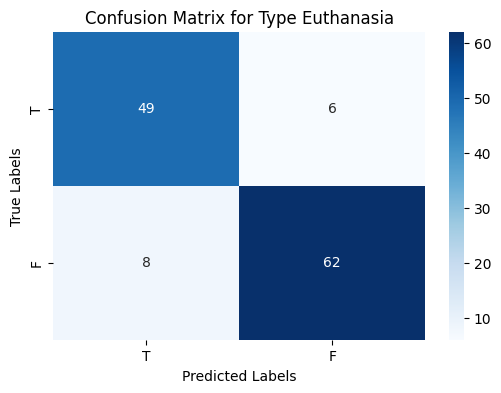

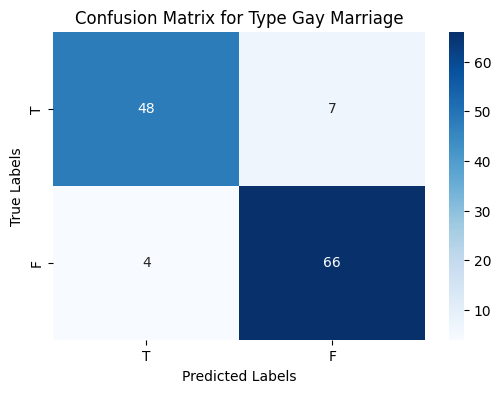

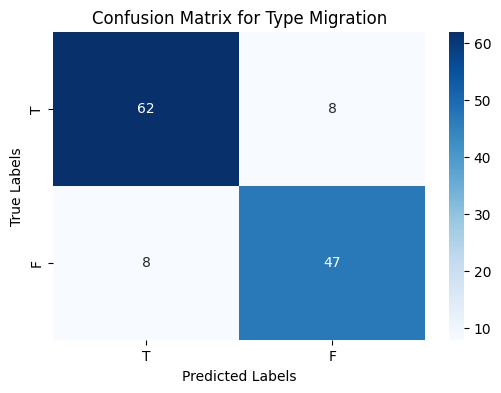

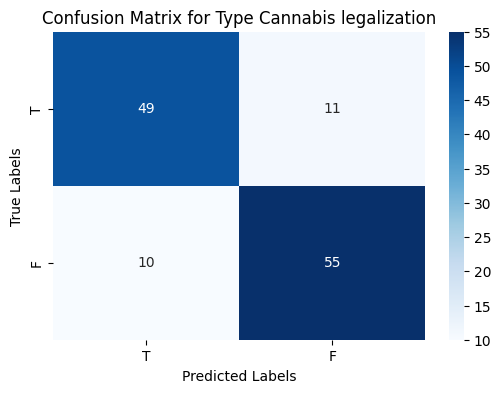

In [ ]:
# Create confusion matrices for each type
for t in unique_types:
    type_mask = (types == t)
    type_true_labels = true_labels[type_mask]
    type_predicted_labels = predicted_labels[type_mask]

    # Create a confusion matrix
    conf_matrix = confusion_matrix(type_true_labels, type_predicted_labels, labels=['T', 'F'])

    # Display the confusion matrix using seaborn heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['T', 'F'], yticklabels=['T', 'F'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for Type {t}')
    plt.show()

3.4 Forth fold

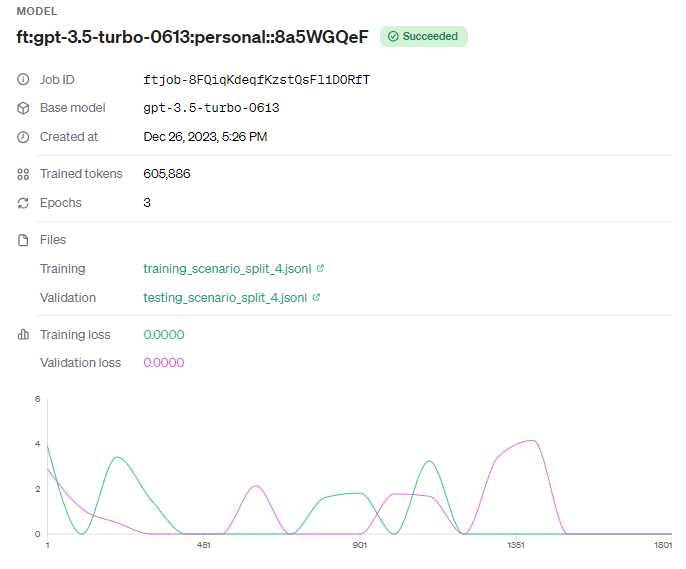

In [ ]:
# Specify the file path
excel_file_path = '/content/testing_scenario_split_4.xlsx'

# Read the Excel file into a DataFrame
df_testing_scenario_split_4 = pd.read_excel(excel_file_path)
df_testing_scenario_split_4['labels'] = df_testing_scenario_split_4['labels'].replace({True: 'T', False: 'F'})

# Display the DataFrame
df_testing_scenario_split_4.head()

,ID,sent,labels,type
0,2,I believe in a woman's right to choose to abor...,F,Abortion
1,2,I don't believe in taking one's own life. Only...,T,Euthanasia
2,2,I am against gay marriage. The Bible is my gu...,T,Gay Marriage
3,2,We should allow all migrants in to this countr...,F,Migration
4,2,I am for cannabis legalization for medicinal p...,T,Cannabis legalization


In [ ]:
fine_tuned_model_id_4cv = 'ft:gpt-3.5-turbo-0613:personal::8a5WGQeF'
store_predictions(df_testing_scenario_split_4, fine_tuned_model_id_4cv)
predictions_4cv_df = pd.read_csv("predictions.csv")

3.4.1 Forth fold overall metrics

In [12]:
true_labels = predictions_4cv_df['labels']
predicted_labels = predictions_4cv_df['Prediction']

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Precision: {precision:.4f}")

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"Recall: {recall:.4f}")

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='binary', pos_label='T')
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.8624
Precision: 0.8558
Recall: 0.8669
F1 Score: 0.8613


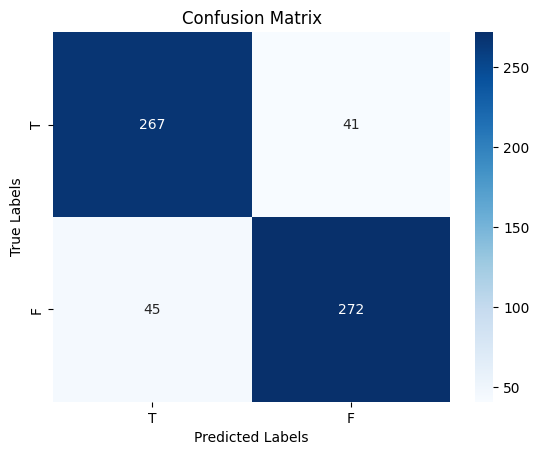

In [13]:
# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['T', 'F'])

# Display the confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['T', 'F'], yticklabels=['T', 'F'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

3.4.2 Forth fold metrics for each statement type

In [ ]:
true_labels = predictions_4cv_df['labels']
predicted_labels = predictions_4cv_df['Prediction']
types = predictions_4cv_df['type']

# Calculate overall metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='binary', pos_label='T')
recall = recall_score(true_labels, predicted_labels, average='binary', pos_label='T')
f1 = f1_score(true_labels, predicted_labels, average='binary', pos_label='T')

print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall: {recall:.4f}")
print(f"Overall F1 Score: {f1:.4f}")
print()

# Calculate metrics for each type
unique_types = predictions_4cv_df['type'].unique()

for t in unique_types:
    type_mask = (types == t)
    type_true_labels = true_labels[type_mask]
    type_predicted_labels = predicted_labels[type_mask]

    type_accuracy = accuracy_score(type_true_labels, type_predicted_labels)
    type_precision = precision_score(type_true_labels, type_predicted_labels, average='binary', pos_label='T')
    type_recall = recall_score(type_true_labels, type_predicted_labels, average='binary', pos_label='T')
    type_f1 = f1_score(type_true_labels, type_predicted_labels, average='binary', pos_label='T')

    print(f"Metrics for Type {t}:")
    print(f"  Accuracy: {type_accuracy:.4f}")
    print(f"  Precision: {type_precision:.4f}")
    print(f"  Recall: {type_recall:.4f}")
    print(f"  F1 Score: {type_f1:.4f}")
    print()

Overall Accuracy: 0.8624
Overall Precision: 0.8558
Overall Recall: 0.8669
Overall F1 Score: 0.8613

Metrics for Type Abortion:
  Accuracy: 0.8640
  Precision: 0.8947
  Recall: 0.8226
  F1 Score: 0.8571

Metrics for Type Euthanasia:
  Accuracy: 0.8880
  Precision: 0.8657
  Recall: 0.9206
  F1 Score: 0.8923

Metrics for Type Gay Marriage:
  Accuracy: 0.8800
  Precision: 0.8636
  Recall: 0.9048
  F1 Score: 0.8837

Metrics for Type Migration:
  Accuracy: 0.8640
  Precision: 0.8814
  Recall: 0.8387
  F1 Score: 0.8595

Metrics for Type Cannabis legalization:
  Accuracy: 0.8160
  Precision: 0.7778
  Recall: 0.8448
  F1 Score: 0.8099



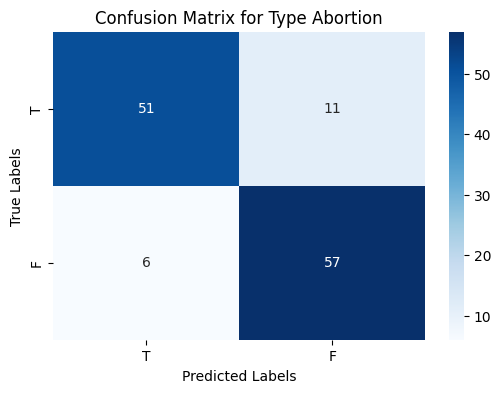

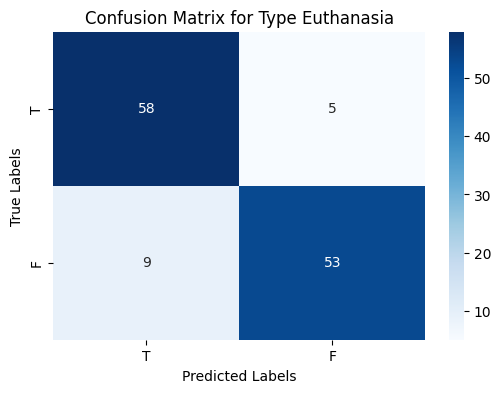

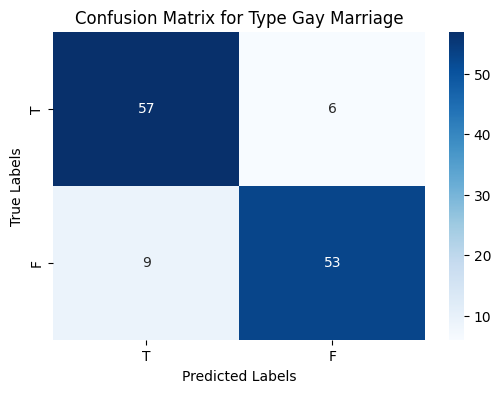

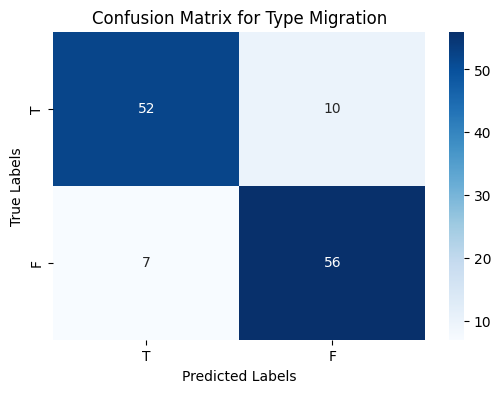

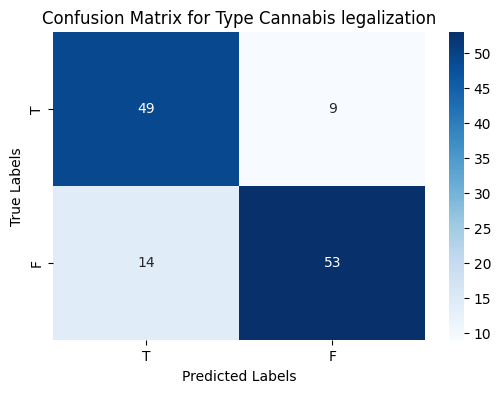

In [ ]:
for t in unique_types:
    type_mask = (types == t)
    type_true_labels = true_labels[type_mask]
    type_predicted_labels = predicted_labels[type_mask]

    # Create a confusion matrix
    conf_matrix = confusion_matrix(type_true_labels, type_predicted_labels, labels=['T', 'F'])

    # Display the confusion matrix using seaborn heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['T', 'F'], yticklabels=['T', 'F'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for Type {t}')
    plt.show()

3.5 Metrics for the entire four-fold cross-validation

In [14]:
# Accuracy values
accuracy_values = [0.8816, 0.8512, 0.8688, 0.8624]

# average and standard deviation
average_accuracy = np.mean(accuracy_values)
std_dev_accuracy = np.std(accuracy_values)

# Print the results
print(f"Average Accuracy: {average_accuracy:.4f}")
print(f"Standard Deviation of Accuracy: {std_dev_accuracy:.4f}")

Average Accuracy: 0.8660
Standard Deviation of Accuracy: 0.0110
